# Objective
*   Remove the logo in the national ID and replace it with the color of the background.



# Approach
*   Utilize the SIFT algorithm for feature extraction.
*   Use the FLANN algorithm for features matching to capture the logo area.
*   Set a bounding box surronds the area.
*   Fill the bounding box area using opencv's inpainting tool.


# Install required libraries

In [ ]:
!pip install numpy
!pip install opencv-python
!pip install matplotlib

# Import libraries

In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os

# Function implementation

In [8]:
def inpaint_image(input_image_path, output_image_path): # Function takes the input image path and the output image path

    # Set constants and paths
    MIN_MATCH_COUNT = 10  #Set feature matches threshold
    reference_image_path = 'ref.png'  # Path to the reference image

    # Load the reference and onput image in color and grayscale
    ref_img = cv.imread(reference_image_path)  # Read reference image
    ref_img_gray = cv.cvtColor(ref_img, cv.COLOR_BGR2GRAY)  # Convert reference image to grayscale
    input_img = cv.imread(input_image_path)  # Read input image
    input_img_gray = cv.cvtColor(input_img, cv.COLOR_BGR2GRAY)  # Convert input image to grayscale

    # Initiate SIFT detector
    sift = cv.SIFT_create()

    # Find the keypoints and descriptors with SIFT for the reference and input image
    kp_ref, des_ref = sift.detectAndCompute(ref_img_gray, None)
    kp_input, des_input = sift.detectAndCompute(input_img_gray, None)

    # Set FLANN algorithm parameters and intiate it
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5) # Use KDTREE algorithm
    search_params = dict(checks=50)
    flann = cv.FlannBasedMatcher(index_params, search_params)  # Initiate FLANN matcher

    # Match descriptors
    matches = flann.knnMatch(des_ref, des_input, k=2)  # Use KNN matcher

    # Store all the good matches using Lowe's Ratio Test
    good = []
    acc = 0.80  #required accuracy
    for m, n in matches:
        if m.distance < acc * n.distance:
            good.append(m)

    # Compute homography
    if len(good) > MIN_MATCH_COUNT:  # Check for suffecient matches
        src_pts = np.float32([kp_ref[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_input[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)  #Use RANSAC
        matchesMask = mask.ravel().tolist()

        # Transform bounding box
        h, w = ref_img_gray.shape
        pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
        dst = np.int32(cv.perspectiveTransform(pts, M)) # Bounding box coordinates

        # Choosing color for inpainting
        x_min = dst[:, 0, 0].min()
        x_max = dst[:, 0, 0].max()
        y_center = int((dst[:, 0, 1].min()/2) + (dst[:, 0, 1].max()/2))
        left_color = input_img[y_center, x_min]  # Get color at the left of the box
        right_color = input_img[y_center, x_max]  # Get color at the right of the box
        avg_color = np.uint8((left_color/2) + (right_color/2))  # Calculate the average color

        # Create a mask for inpainting
        inpaint_mask = np.zeros(input_img.shape[:2], dtype=np.uint8)
        cv.fillPoly(inpaint_mask, [dst], 255)

        # Fill the bounding box
        inpainted_img = cv.inpaint(input_img, inpaint_mask, 3, cv.INPAINT_TELEA)
        filled_img = inpainted_img.copy()
        filled_img[inpaint_mask == 255] = avg_color

        # Save the output image
        cv.imwrite(output_image_path, filled_img)

    else:
        print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))


# Folder extraction

In [1]:
!unzip input.zip

Archive:  input.zip
   creating: input/
  inflating: input/15.jpg            
  inflating: input/2.jpg             
  inflating: input/21.jpg            
  inflating: input/44.jpg            
  inflating: input/48.jpg            
  inflating: input/51.jpg            
  inflating: input/52.jpg            
  inflating: input/55.jpg            
  inflating: input/9.jpg             


# Test cases

In [15]:
# Set folders paths
input_folder = 'input'
output_folder = 'output'

# Ensure the output folder exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Loop through all images in the input folder
formats = ('.jpeg', '.jpg', '.png')
for filename in os.listdir(input_folder):
    if filename.endswith(formats):
        input_image_path = os.path.join(input_folder, filename)
        output_image_path = os.path.join(output_folder, filename)
        inpaint_image(input_image_path, output_image_path)


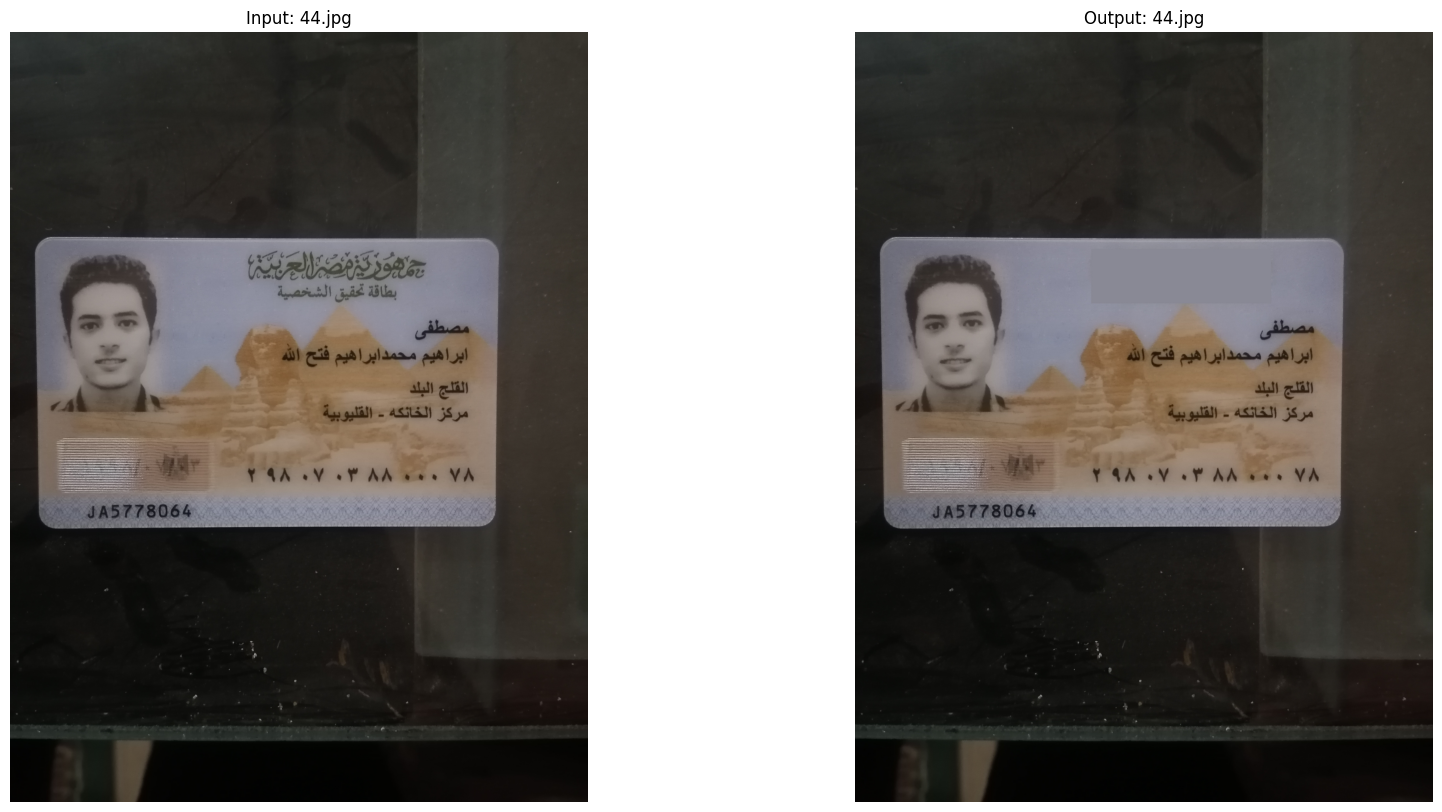

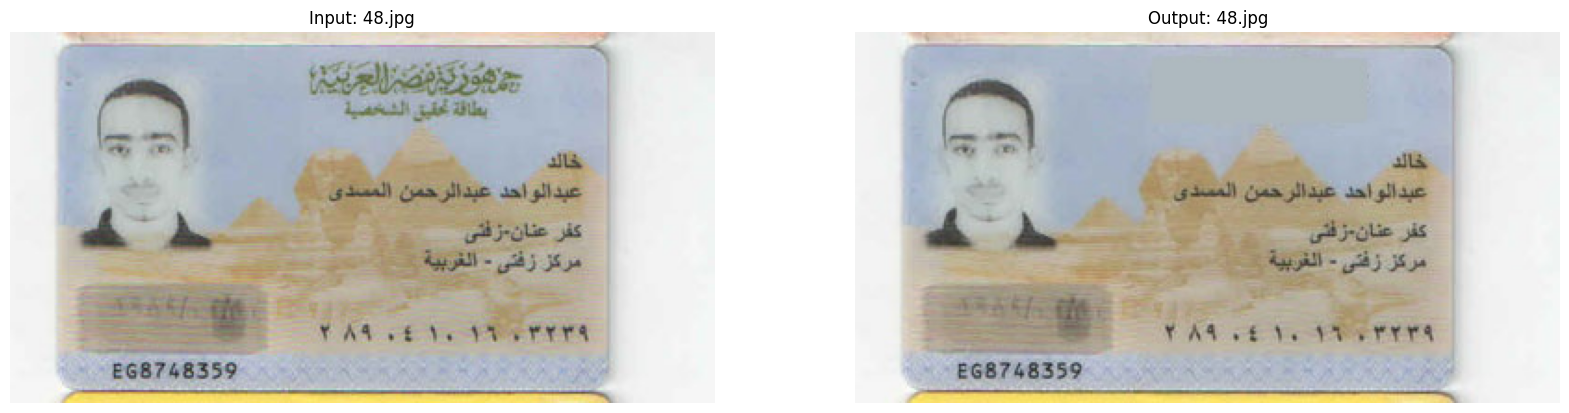

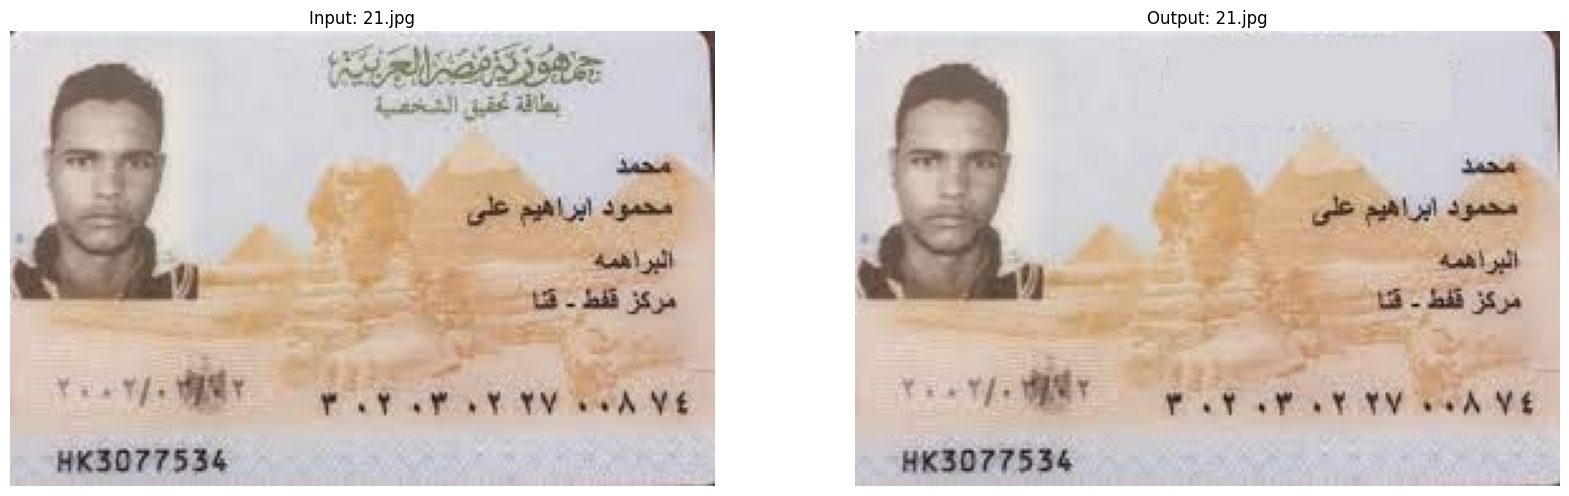

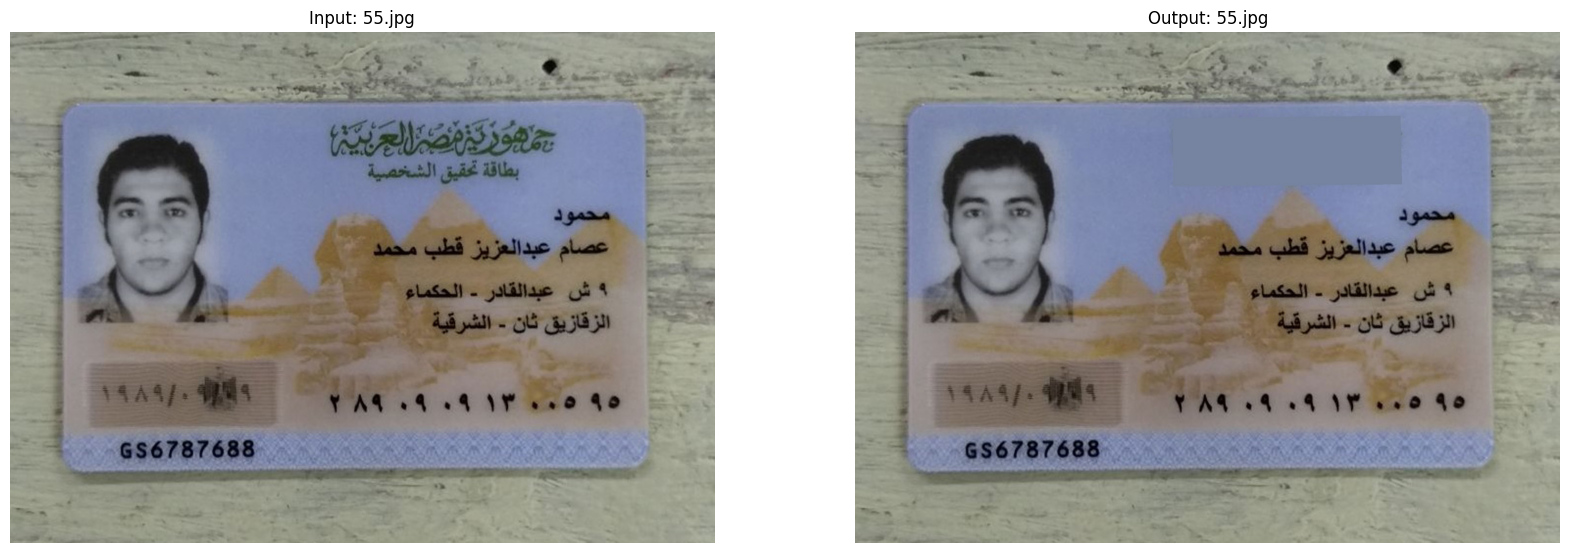

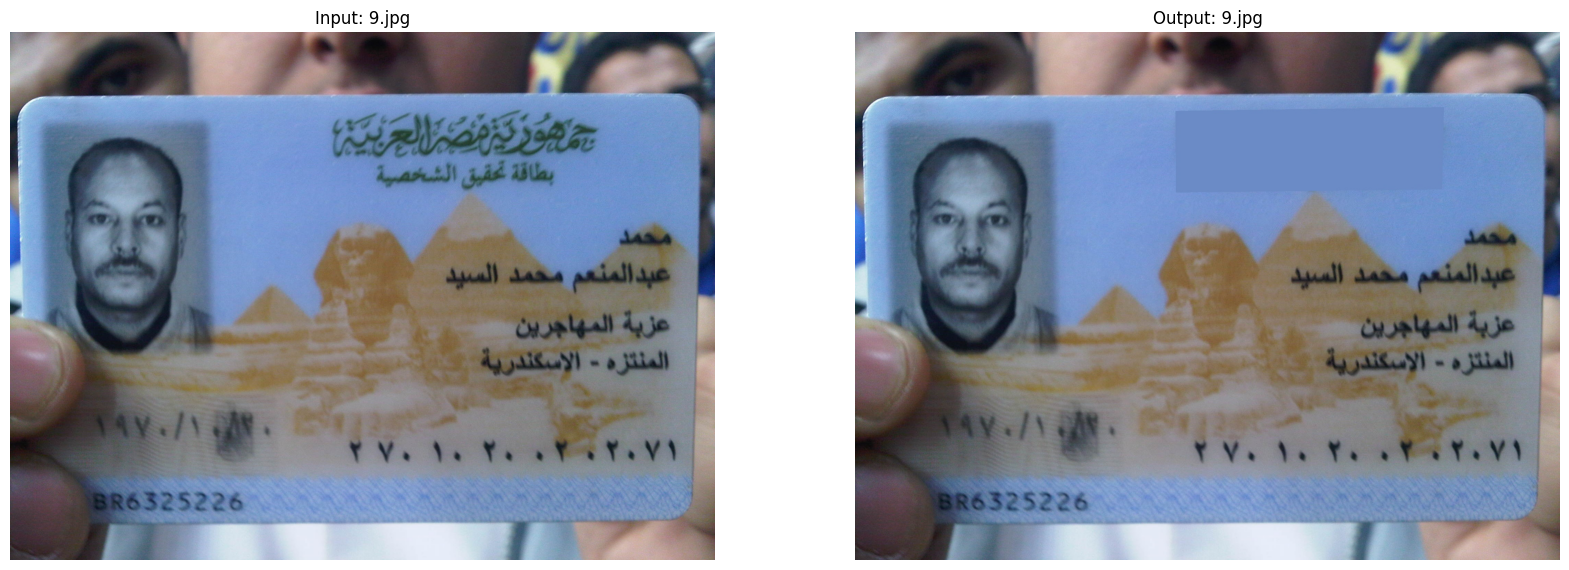

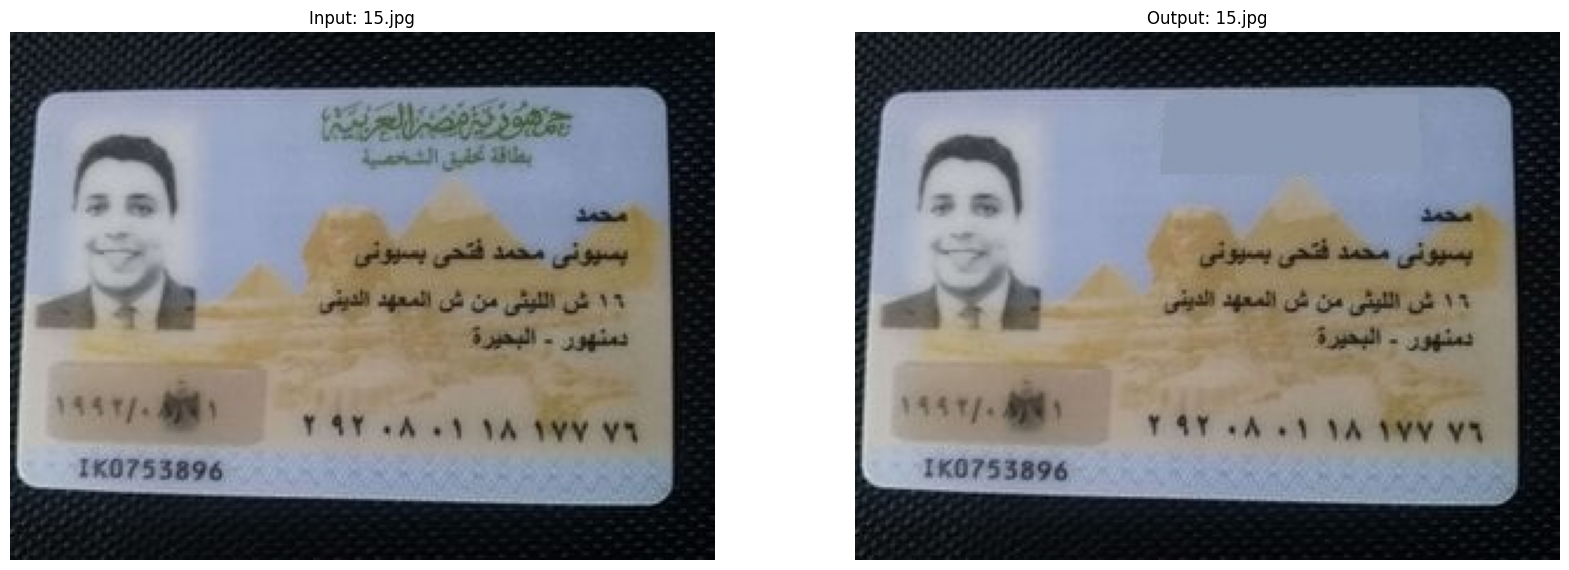

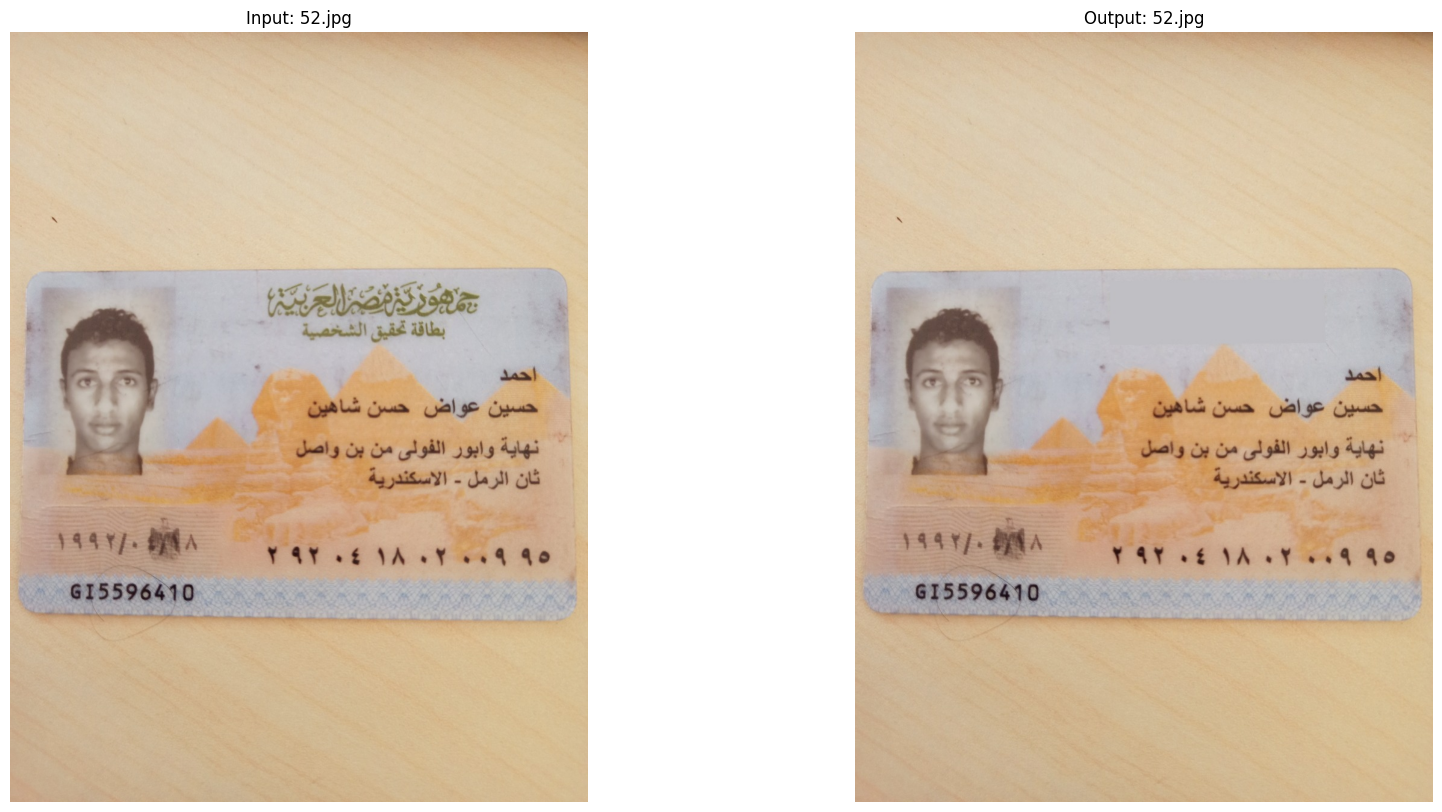

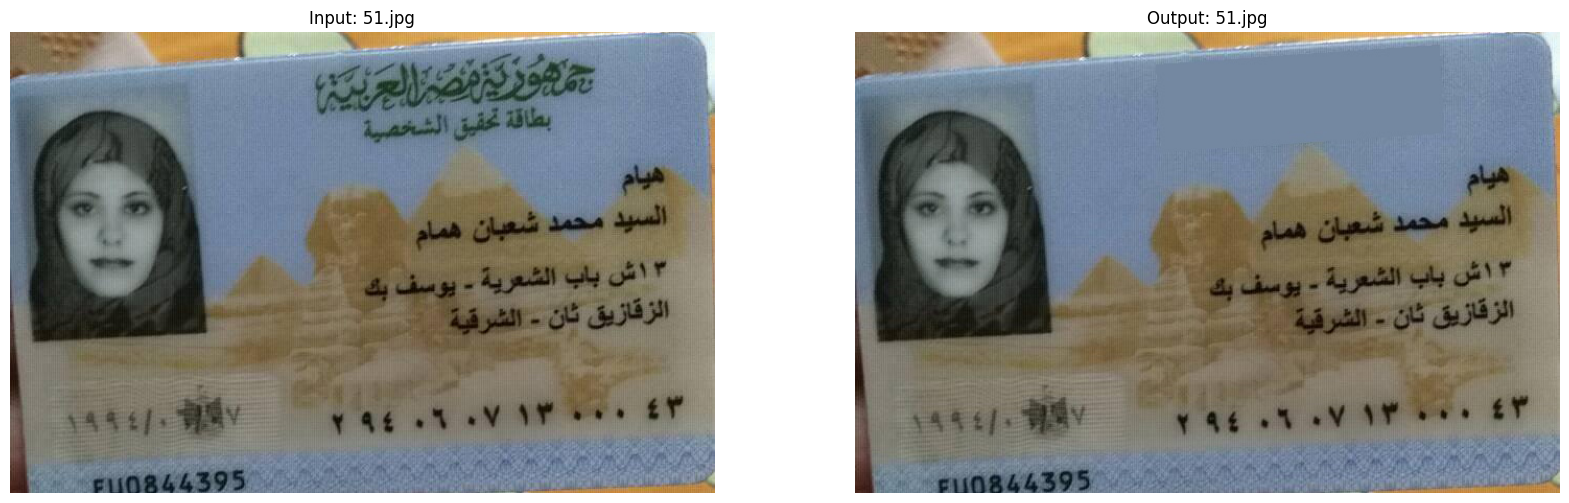

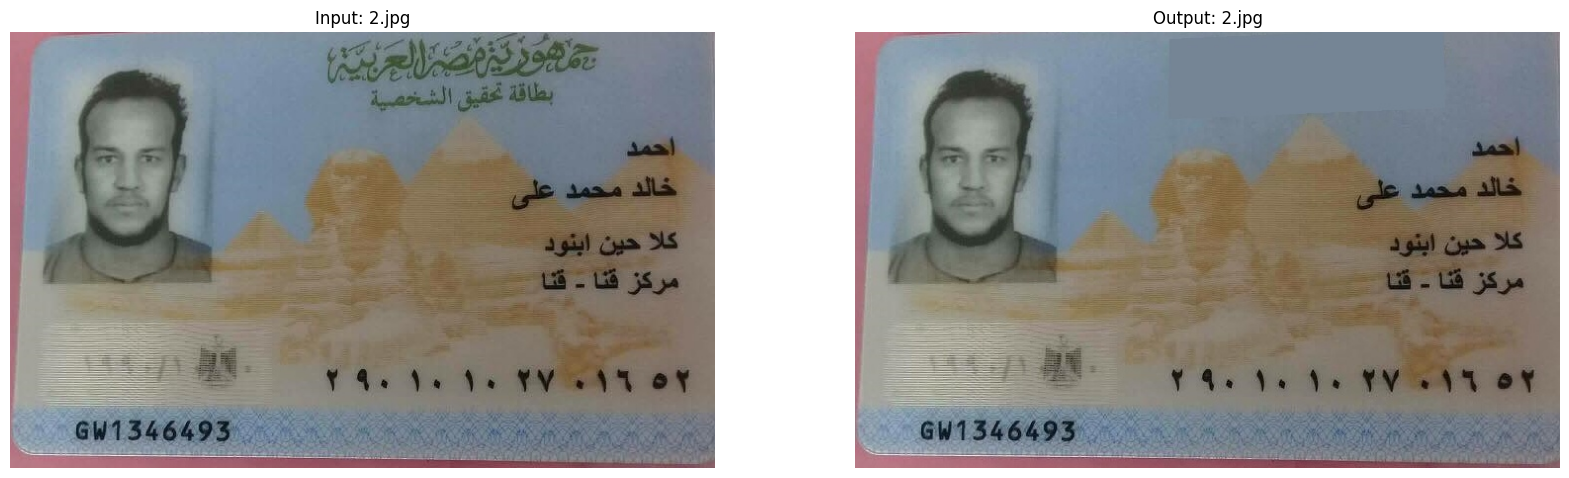

In [17]:
def display_side_by_side(input_folder, output_folder):
    # Ensure both folders exist
    if not os.path.exists(input_folder):
        print(f"Folder '{input_folder}' does not exist.")
        return
    if not os.path.exists(output_folder):
        print(f"Folder '{output_folder}' does not exist.")
        return

    # List all files in the input folder
    input_files = os.listdir(input_folder)
    input_image_files = [f for f in input_files if f.endswith(('.jpeg', '.jpg', '.png'))]

    # Display images side by side
    for image_file in input_image_files:
        input_image_path = os.path.join(input_folder, image_file)
        output_image_path = os.path.join(output_folder, image_file)

        if os.path.exists(output_image_path):
            input_image = cv.imread(input_image_path)
            output_image = cv.imread(output_image_path)

            input_image_rgb = cv.cvtColor(input_image, cv.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying with matplotlib
            output_image_rgb = cv.cvtColor(output_image, cv.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying with matplotlib

            # Display side by side
            fig, axs = plt.subplots(1, 2, figsize=(20, 10))
            axs[0].imshow(input_image_rgb)
            axs[0].set_title(f'Input: {image_file}')
            axs[0].axis('off')

            axs[1].imshow(output_image_rgb)
            axs[1].set_title(f'Output: {image_file}')
            axs[1].axis('off')

            plt.show()
        else:
            print(f"Output image '{image_file}' does not exist in '{output_folder}'.")

# Set the folder paths
input_folder = 'input'
output_folder = 'output'

# Display images side by side
display_side_by_side(input_folder, output_folder)
